In [1]:
import numpy as np
import scipy as sp
from scipy import signal
import sklearn as sk
from sklearn import neighbors
import preprocessing as pp
import utilities as u
import MAPInference as mapi
from matplotlib import pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
df = pp.load_session_db(dir="E:\\")
# df = pp.load_session_db()
df = df[df['RewardCount']>20]
# df = df[df['Imaging']==1]
df = df.sort_values(['MouseName','DateTime','SessionNumber'])
df = df[df["Track"]=="TwoTower_foraging"]

In [3]:
mice = ['4139265.3','4139265.4','4139265.5','4222168.1','4343703.1','4343706','4222153.1','4222153.2',
        '4222153.3','4222174.1','4222154.1','4343702.1']

In [4]:
getf = lambda s : s*2.5 + (1-s)*3.5
gettheta = lambda s: (s*60. + (1-s)*10.)*np.pi/180
xfreq = lambda s: np.abs(getf(s)*1500/120*(np.cos(gettheta(s) + np.pi/4.)-np.sin(gettheta(s)+np.pi/4.))) 
yfreq = lambda s: np.abs(getf(s)*1500/120*(np.cos(gettheta(s) + np.pi/4.)+np.sin(gettheta(s)+np.pi/4.))) 
ang = lambda x,y: np.arctan(x/y)*180/np.pi

def single_mouse_data(mouse):
    df_mouse = df[df["MouseName"]==mouse]
    data = {}
    for i in range(1,df_mouse.shape[0]):
        sess = df_mouse.iloc[i]
        date, num = sess['DateFolder'],sess['SessionNumber']
        VRDat = pp.behavior_dataframe(sess["data file"])
        trial_info, tstarts_, teleports_ = u.by_trial_info(VRDat)
        key = date + str(num) 
        wall = trial_info['morphs']+trial_info['wallJitter']
#         print(np.amax(wall),np.amin(wall))
        wallfreq= (xfreq(wall) - xfreq(-.1))/(xfreq(1.1)-xfreq(-.1))*1.2-.1
#         print(np.amax(wallfreq),np.amin(wallfreq))
        bckgnd = trial_info['morphs']+trial_info['bckgndJitter']

        tower = np.minimum(np.maximum(trial_info['morphs']+trial_info['towerJitter'],0),1)

        data[key]=np.concatenate((wallfreq[:,np.newaxis],wall[:,np.newaxis],bckgnd[:,np.newaxis],tower[:,np.newaxis]),axis=1)
    return data

def single_mouse_em_all(mouse,data = None):
    if data is None:
        data = single_mouse_data(mouse)
    else:
        pass
    
    for i, (key,arr) in enumerate(data.items()):
        if i == 0:
            em_all = arr
        else:
            em_all = np.concatenate((em_all,arr),axis=0)
    return em_all

def gaussian(mu,sigma,x):
    '''radial basis function centered at 'mu' with width 'sigma', sampled at 'x' '''
    return np.exp(-(mu-x)**2/sigma**2)


In [5]:
for m, mouse in enumerate(mice):
    print(mouse)
    if m ==0:
        EM_all = single_mouse_em_all(mouse)
    else:
        EM_all = np.concatenate((EM_all,single_mouse_em_all(mouse)),axis=0)
    
        



4139265.3


C:\Users\markp\anaconda3\lib\site-packages\pandas\core\frame.py:4244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  **kwargs


4139265.4
4139265.5
4222168.1
deleting last index from trial start
deleting last index from trial start
4343703.1
4343706
4222153.1
4222153.2
4222153.3
4222174.1
4222154.1
4343702.1


[223.80988966  19.18770107   8.95975498   8.25462627]
(4, 4)
(27008, 4)
[[-0.57024154 -0.47801596 -0.47709651 -0.46765827]
 [-0.80666675  0.20041733  0.46581769  0.30353834]
 [ 0.15239858 -0.79123722  0.59190731  0.01908039]
 [-0.02979948 -0.32446463 -0.45281181  0.82993744]]


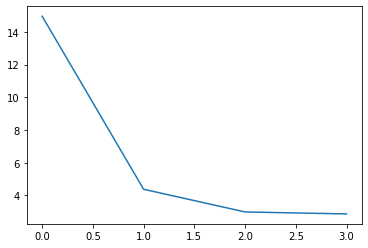

In [6]:
u_,s_,vh_ = np.linalg.svd(EM_all,full_matrices=False)
print(s_)
print(vh_.shape)
print(u_.shape)
print(vh_)

f,ax = plt.subplots()
ax.plot(s_**.5)

vh_norm = vh_/vh_.sum(axis=1,keepdims=True)

In [7]:
em_all = single_mouse_em_all('4139265.5')

In [8]:
print(np.amax(em_all,axis=0))

[1.10006025 1.09968958 1.09984372 1.        ]


In [91]:
# em_all1d =  np.dot(em_all,vh_norm[0,:].T)
em_all1d = em_all[:,0]

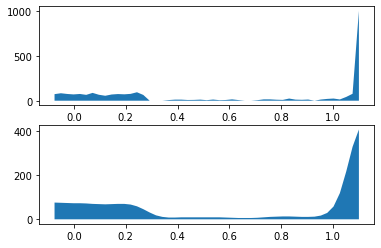

In [97]:
hist,edges = np.histogram(em_all1d,bins=np.linspace(np.amin(em_all1d),np.amax(em_all1d),num=50))
f,ax = plt.subplots(2,1)
ax[0].fill_between(edges[1:],hist)
ax[1].fill_between(edges[1:],sp.ndimage.filters.gaussian_filter1d(hist,2))
hist_sm = sp.ndimage.filters.gaussian_filter1d(hist,4)

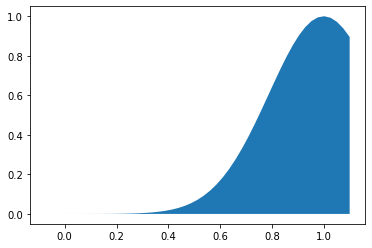

In [98]:
l = gaussian(1,.3,edges[1:])
f,ax = plt.subplots()
ax.fill_between(edges[1:],l)

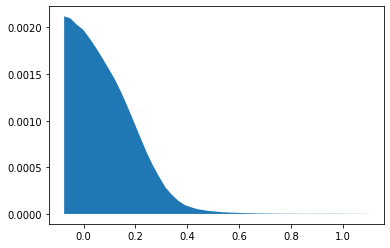

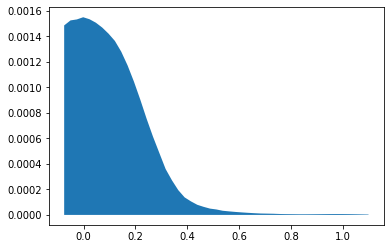

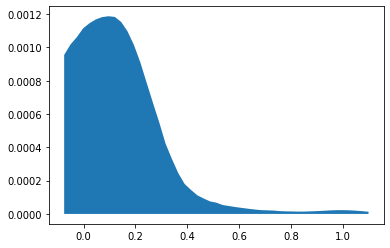

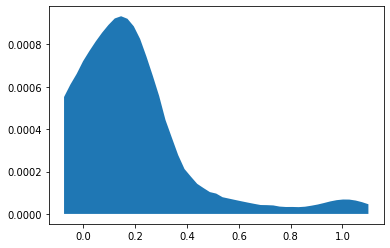

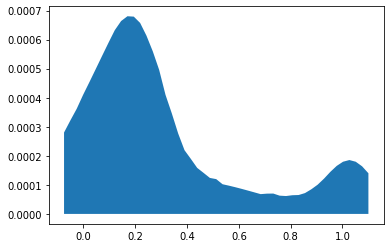

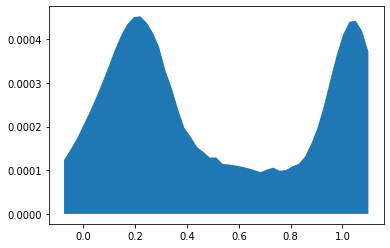

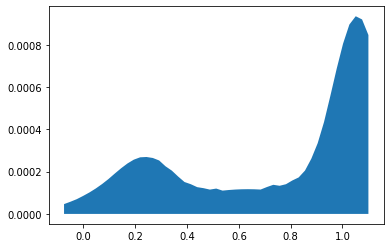

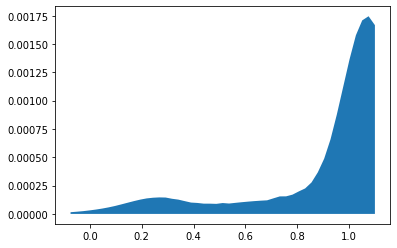

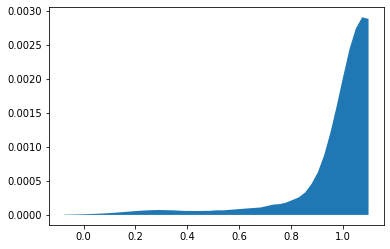

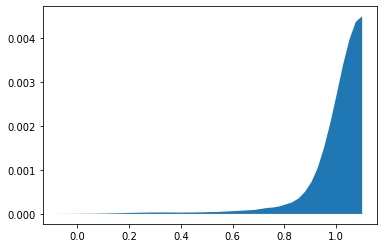

In [99]:
hist_sm =hist_sm /hist_sm.sum()
mus = np.linspace(-.1,1.1)
shat = np.zeros(mus.shape)
for i,s in enumerate(mus):
    l = gaussian(s,.4,edges[1:])
    l=l/l.sum()
    post = hist_sm*l
    
    shat[i] = edges[np.argmax(post)]
    if i%5==0:
        f,ax = plt.subplots()
        ax.fill_between(edges[1:],post)
    
    


(1.1, -0.1)

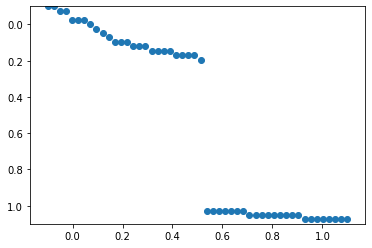

In [100]:
f,ax = plt.subplots()
ax.scatter(mus,shat)
ax.set_ylim([1.1,-.1])

### Confirming recapitualation of Unity planes

In [23]:
# ensure texture looks the same as unity

intens = lambda xs,ys, f, theta: np.cos(2.*np.pi*f*(xs*(np.cos(theta + np.pi/4.)+np.sin(theta+np.pi/4.)) + ys*(np.cos(theta+np.pi/4.)-np.sin(theta+np.pi/4))))


In [26]:
f1,f2 = 2.5,3.5
theta1,theta2 = 60.,10.
morph = 1.
f = morph*f1 + (1-morph)*f2
print(f)
theta = (morph*theta1  + (1-morph)*theta2) * np.pi / 180
print(theta)
texture = np.zeros([120,1500])
for y in range(texture.shape[1]):
    for x in range(texture.shape[0]):
        xs = x/texture.shape[1]*1
        ys = y/texture.shape[0]*1
        texture[x,y]=intens(xs,ys,f,theta)#+ intens(ys,xs,f,theta)
print(xs,ys)

2.5
1.0471975511965976
0.07933333333333334 12.491666666666667


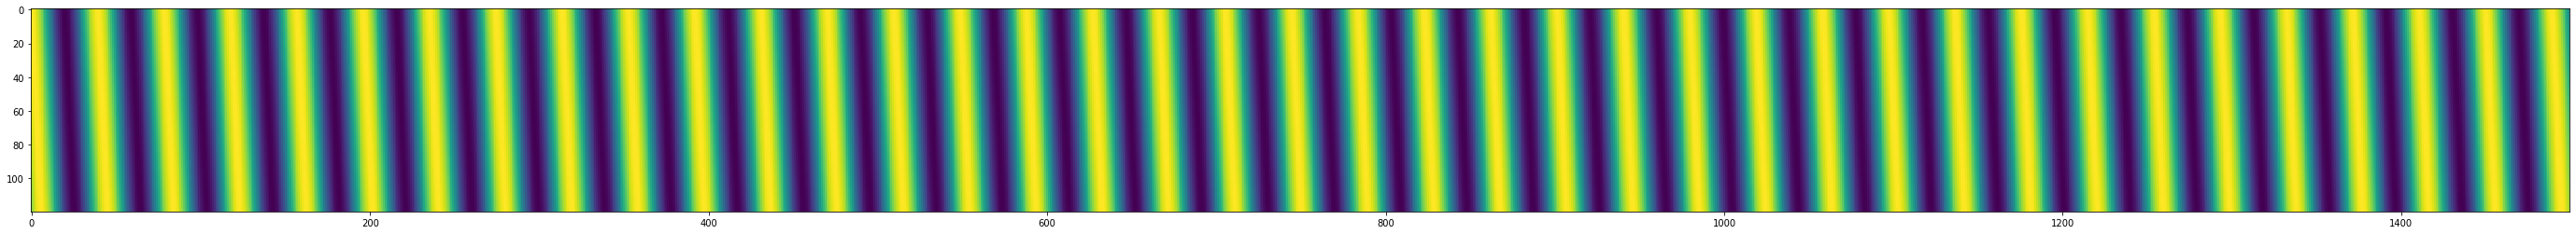

In [27]:
f,ax = plt.subplots(1,1,figsize=[50,4],sharex=True)
ax.imshow(texture)


In [28]:
xfreq = lambda f,theta: f*1500/120*(np.cos(theta + np.pi/4.)-np.sin(theta+np.pi/4.)) 
yfreq = lambda f,theta: f*1500/120*(np.cos(theta + np.pi/4.)+np.sin(theta+np.pi/4.)) 

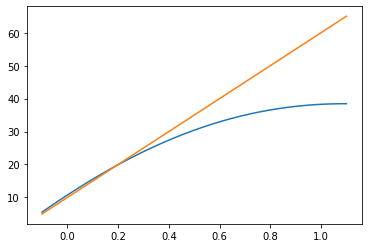

In [29]:
morphs = np.linspace(-.1,1.1,num=1000)
# xcoeff = np.zeros(morphs.shape)
f,theta = morphs*f1 + (1-morphs)*f2, (morphs*theta1  + (1-morphs)*theta2) * np.pi / 180
xcoeff = xfreq(f,theta)
ycoeff = yfreq(f,theta)
fig,ax = plt.subplots()
ax.plot(morphs,np.abs(xcoeff))
# ax.plot(morphs,np.abs(ycoeff))
ang = np.abs(np.arctan(xcoeff/ycoeff)*180/np.pi)
ax.plot(morphs,ang)